In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [13]:
# Variáveis para o gráfico
plot_params = {'legend.fontsize': 30,
               'figure.figsize': (20, 10),
               'axes.labelsize':  30,
               'axes.titlesize':  30,
               'xtick.labelsize': 25,
               'ytick.labelsize': 25}

plt.style.use('ggplot')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

color = [color_dark_blue, color_light_blue, purple]

In [15]:
S0_normalizing = 110
sigma0 = 0.2

def LocalVolExample(t, S):

    y = np.log(S/S0_normalizing)
    tau = T_final - t
    
    lv = sigma0 * (S < 1.1*K) + sigma0/2 * (S > 1.1*K) 

    return lv

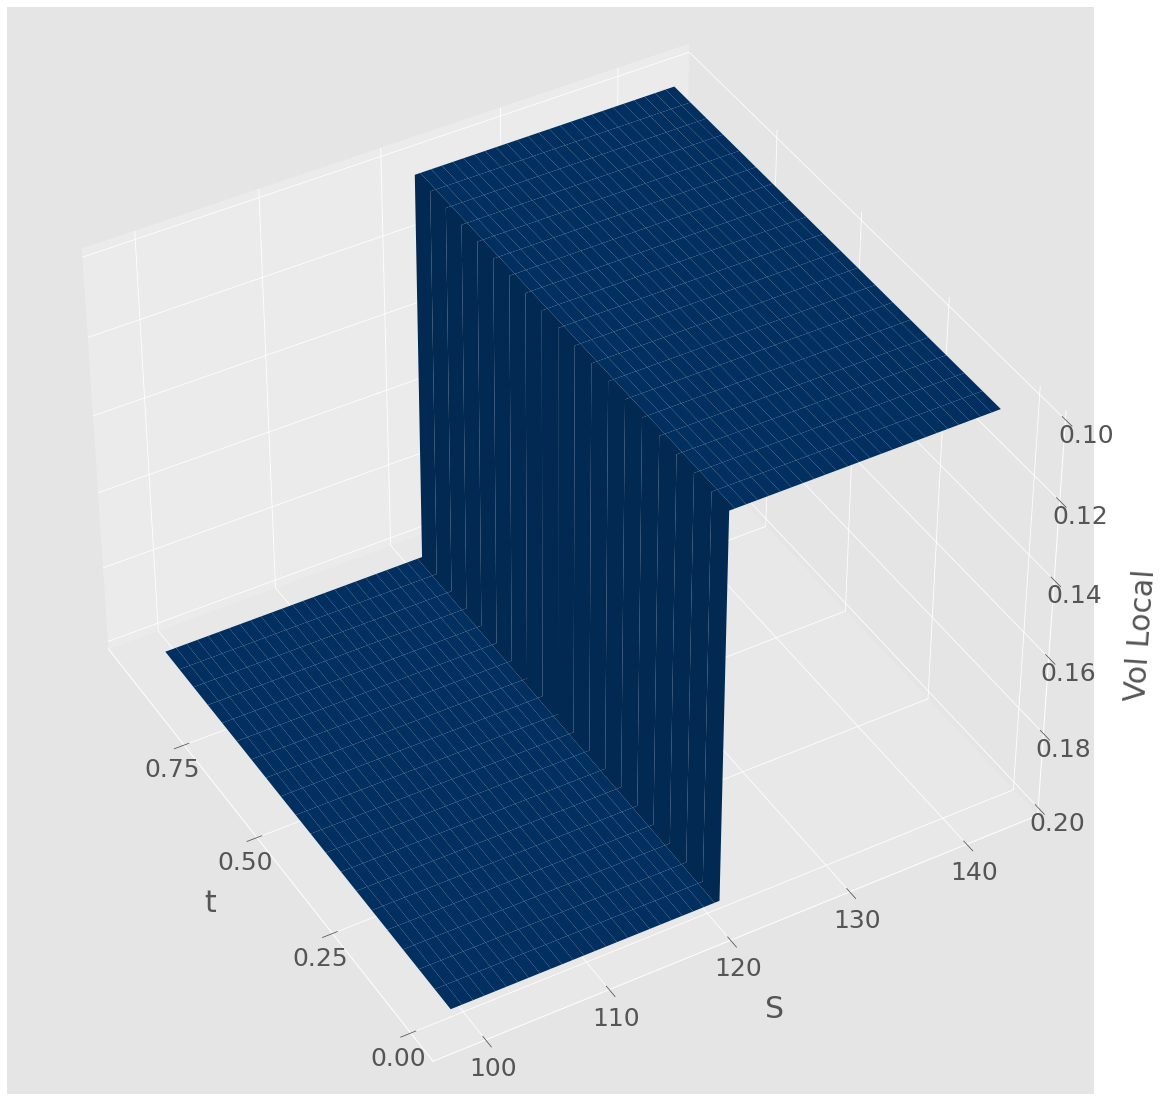

In [29]:
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection='3d')
plt.locator_params(nbins=5)
ax.view_init(-140, 30)

t = np.arange(0.0, T, 0.05)
s = np.arange(0.9*S0_normalizing, 1.3*S0_normalizing, 0.05)
t, s = np.meshgrid(t, s)
vols = np.array(LocalVolExample(np.ravel(t), np.ravel(s)))
vol = vols.reshape(s.shape)

ax.plot_surface(t, s, vol, color=color_dark_blue)

ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('Vol Local')

ax.yaxis.labelpad=30
ax.xaxis.labelpad=30
ax.zaxis.labelpad=30

plt.show()

In [55]:
def LocalVolSimulation(S0, r, local_vol, time, dW):
    '''
    Função que calcula o preço de uma call (T,K) com barreira H no modelo de Black-Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    r (float) - taxa de juros livre de risco
    local_vol (function(t,S)) - volatilidade local
    time (array) - vetor com tempo de 0 a maturidade T
    dW (array) - incrementos do mov. Browniano
    '''    
    N = len(time)-1
    M = dW.shape[1]
    dt = time[1] - time[0]

    S = np.zeros((N+1, M))

    S[0, :] = S0

    for t in range(N-1):
        vol = local_vol(time[t], S[t, :])
        S[t+1, :] = S[t, :] * np.exp((r - 0.5 * vol**2) * dt + vol * dW[t, :])

    return S

In [56]:
def LocalVolBarrierPrice(S0, K, H, r, local_vol, time, dW):
    '''
    Função que calcula o preço de uma call (T,K) com barreira H no modelo Volatilidade Local
    S0 (float > 0) - valor inicial do ativo subjacente
    K (float > 0) - strike
    H (float > 0) - barreira
    r (float) - taxa de juros livre de risco
    local_vol (function(t,S)) - volatilidade local
    time (array) - vetor com tempo de 0 a maturidade T
    M (int) - número de simulações para estimação por Monte Carlo
    '''
    T = time[-1] #maturidade
    
    simulated_path = LocalVolSimulation(S0, r, local_vol, time, dW) #simulação do ativo

    max_S = np.max(simulated_path, axis=0) #valor máximo do ativo
    ST = simulated_path[-1, :] #valor do ativo na maturidade

    payoff = np.maximum(ST - K, 0.0) * (max_S < H) #payoff

    C = np.exp(-r*T) * np.mean(payoff) #preço MC da opção

    error = np.exp(-r*T) * np.std(payoff)/np.sqrt(M) #erro padrão do MC

    return C, error

In [57]:
def BSBarrierPrice(S0, K, H, r, sigma, time, dW):
    '''
    Função que calcula o preço de uma call (T,K) com barreira H no modelo de Black-Scholes
    S0 (float > 0) - valor inicial do ativo subjacente
    K (float > 0) - strike
    H (float > 0) - barreira
    r (float) - taxa de juros livre de risco
    sigma (float > 0) - volatilidade de Black-Scholes
    time (array) - vetor com tempo de 0 a maturidade T
    M (int) - número de simulações para estimação por Monte Carlo
    '''
    T = time[-1] #maturidade
    dt = time[1] - time[0]
    
    dX = (r - 0.5 * sigma ** 2) * dt + sigma * dW #simulação do log-retorno

    simulated_path = S0 * np.exp(np.cumsum(dX, axis=0)) #simulação do ativo

    max_S = np.max(simulated_path, axis=0) #valor máximo do ativo
    ST = simulated_path[-1, :] #valor do ativo na maturidade
        
    payoff = np.maximum(ST - K, 0.0) * (max_S < H) #payoff

    C = np.exp(-r*T) * np.mean(payoff) #preço MC da opção

    error = np.exp(-r*T) * np.std(payoff)/np.sqrt(N) #erro padrão do MC

    return C, error

In [58]:
S0 = 100
r = 0.0
T = 1.0
K = 110
H = 130

N = int(1e2)
time = np.linspace(0, T, N+1)

M = int(1e5)
dW = np.sqrt(dt) * np.random.normal(size=(N, M))

barrier_price, error = LocalVolBarrierPrice(S0, K, H, r, LocalVolExample, time, dW)

In [52]:
N_v = 50 # discretização da vol de Black-Scholes
sigma = np.linspace(0.01, 0.5, N_v+1) # variação do sigma de Black-Scholes

barrier_BS = np.zeros_like(sigma)

for i in range(N_v+1):
    barrier_BS[i] = BSBarrierPrice(S0, K, H, r, sigma[i], time, dW)[0]

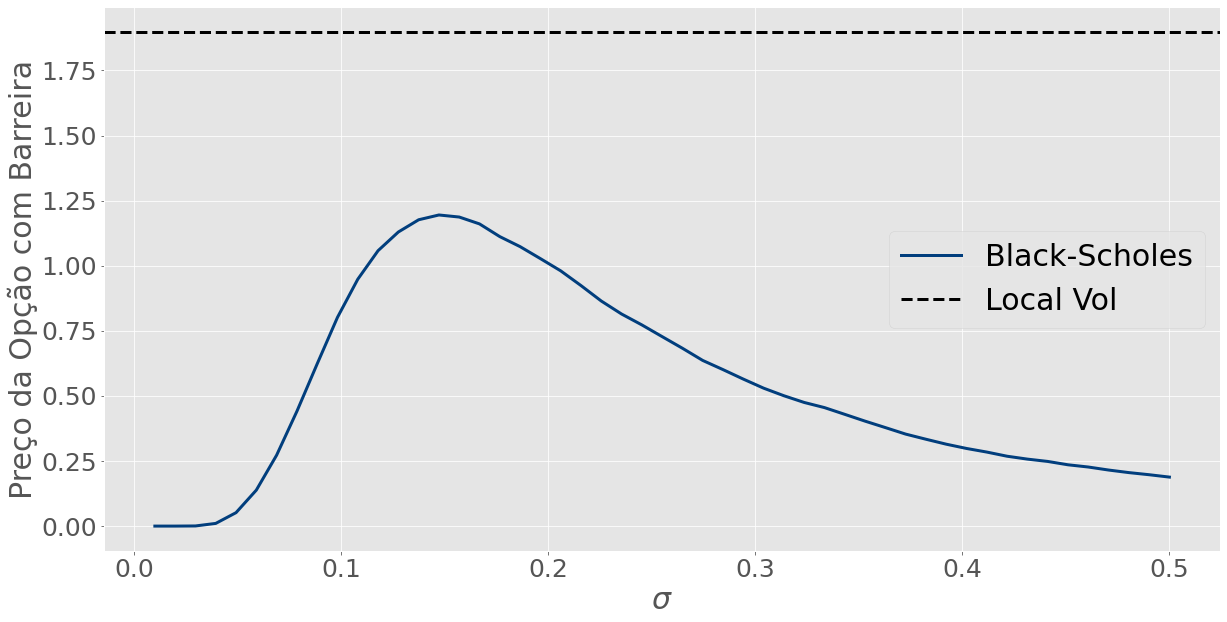

In [54]:
plt.figure()
plt.plot(sigma, barrier_BS, label='Black-Scholes', linewidth=3, color=color_dark_blue)
plt.axhline(barrier_price, color='k', linestyle='dashed', linewidth=3, label='Local Vol')
plt.xlabel(r'$\sigma$')
plt.ylabel('Preço da Opção com Barreira')
plt.legend()